In [499]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [500]:
language = 'es'
assert(language in ['en', 'fr', 'es'])

In [501]:
numberbatch = pickle.load(open(f"/data/zeste_cache/numberbatch-{language}-19.08.pickle", 'rb'))

In [502]:
len(numberbatch.vocab)

651859

In [503]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [504]:
ds_techniques = pd.read_csv('datasets/silknow/zeste_visual_item_es_post.csv').rename(columns={'visual_item':'label'})
ds_techniques.label = ds_techniques.label.str.lower()
ds_techniques.head()

,text,label
0,Tejido rectangular con fondo en color y decora...,http://data.silknow.org/vocabulary/743
1,Edad Moderna,http://data.silknow.org/vocabulary/743
2,"Cenefa enmarcada en tres de sus lados, y recor...",http://data.silknow.org/vocabulary/743
3,Edad Contemporánea,http://data.silknow.org/vocabulary/743
4,Colcha de damasco color rojo con decoración fl...,http://data.silknow.org/vocabulary/743


In [505]:
ds_techniques.label.value_counts()

http://data.silknow.org/vocabulary/743    1467
http://data.silknow.org/vocabulary/744     523
http://data.silknow.org/vocabulary/745     272
http://data.silknow.org/vocabulary/750     228
http://data.silknow.org/vocabulary/759      57
http://data.silknow.org/vocabulary/768      54
http://data.silknow.org/vocabulary/765      47
http://data.silknow.org/vocabulary/793      16
http://data.silknow.org/vocabulary/785      11
http://data.silknow.org/vocabulary/824      10
Name: label, dtype: int64

In [506]:
len(ds_techniques)

2685

In [507]:
def get_word_neighborhood(word, depth=2, allowed_rels='all', keep='top20000', language=language):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods_'+language+'/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if '/c/'+language+'/'+word in numberbatch and '/c/'+language+'/'+ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity('/c/'+language+'/'+word, '/c/'+language+'/'+ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [508]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [509]:
def get_words_neighborhood(words, depth=2, allowed_rels='all', keep='top20000', language=language):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep, language=language))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [510]:
sorted(ds_techniques.label.unique())

['http://data.silknow.org/vocabulary/743',
 'http://data.silknow.org/vocabulary/744',
 'http://data.silknow.org/vocabulary/745',
 'http://data.silknow.org/vocabulary/750',
 'http://data.silknow.org/vocabulary/759',
 'http://data.silknow.org/vocabulary/765',
 'http://data.silknow.org/vocabulary/768',
 'http://data.silknow.org/vocabulary/785',
 'http://data.silknow.org/vocabulary/793',
 'http://data.silknow.org/vocabulary/824']

In [511]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'rosal', 'rosáceo', 'rosa', 'rosado', 'rosaleda', 'rosalista', 'pimpollo'])

In [512]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""

mapping = { 'http://data.silknow.org/vocabulary/744':'planta',
            'http://data.silknow.org/vocabulary/743':'flor',
            'http://data.silknow.org/vocabulary/745':'geometría',
            'http://data.silknow.org/vocabulary/824':'flor',
            'http://data.silknow.org/vocabulary/785':'flor',
            'http://data.silknow.org/vocabulary/793':'planta',
            'http://data.silknow.org/vocabulary/765':'planta',
            'http://data.silknow.org/vocabulary/768':'geometría',
            'http://data.silknow.org/vocabulary/759':'flor',
            'http://data.silknow.org/vocabulary/750':'planta'           
            }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

3
['flor', 'geometría', 'planta']


In [513]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 95.1 ms, sys: 0 ns, total: 95.1 ms
Wall time: 91.2 ms


In [514]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'flor': 475, 'geometría': 164, 'planta': 1418}

In [515]:
labels_cgr.keys()

dict_keys(['flor', 'geometría', 'planta'])

In [516]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [517]:
ds_techniques.text[0]

'Tejido rectangular con fondo en color y decoración a base de capullos de flor en color verde.'

In [518]:
data_silknow = ds_techniques.text.tolist()

In [519]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [520]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_techniques.text)

CPU times: user 67.8 ms, sys: 2.09 s, total: 2.16 s
Wall time: 2.69 s


In [521]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [522]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [523]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 0 ns, sys: 1.71 s, total: 1.71 s
Wall time: 1.61 s


In [524]:


predictions[:10]

[0, 0, 2, 0, 2, 0, 0, 0, 0, 0]

In [525]:

prediction_labels = [labels[p] for p in predictions]

In [526]:
set(prediction_labels)

{'flor', 'geometría', 'planta'}

In [527]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]

# Techniques

In [528]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_techniques["predictions"] = m 
ds_techniques.to_csv('visual-items-es-predictions.csv')

              precision    recall  f1-score   support

        flor      0.952     0.602     0.738      2442
   geometría      0.034     0.647     0.064        17
      planta      0.144     0.518     0.225       226

    accuracy                          0.596      2685
   macro avg      0.377     0.589     0.342      2685
weighted avg      0.878     0.596     0.690      2685



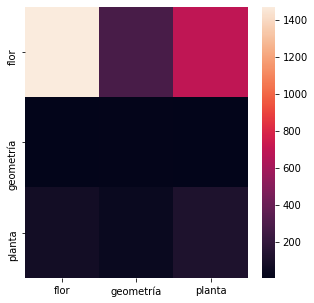

In [529]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

# "Top-k" evaluation

In [530]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

        flor      0.033     0.823     0.063        62
   geometría      0.966     0.994     0.980       317
      planta      0.998     0.352     0.521      2306

    accuracy                          0.439      2685
   macro avg      0.666     0.723     0.521      2685
weighted avg      0.972     0.439     0.564      2685



In [531]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

        flor      1.000     1.000     1.000      1545
   geometría      1.000     1.000     1.000       326
      planta      1.000     1.000     1.000       814

    accuracy                          1.000      2685
   macro avg      1.000     1.000     1.000      2685
weighted avg      1.000     1.000     1.000      2685

